In [1]:
from pathlib import Path
import numpy as np
from scipy.special import erf
import matplotlib.font_manager as fm
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import dask
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
import xarray as xr
import cmocean.cm as cmo

In [3]:
fpath = Path("/System/Library/Fonts/Supplemental/Arial.ttf")
font_prop = fm.FontProperties(fname=fpath)
plt.rcParams['font.family'] = font_prop.get_family()
plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

plt.rc('xtick', labelsize='8')
plt.rc('ytick', labelsize='8')
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 10
plt.rcParams["figure.labelsize"] = 8

#plt.rcParams["text.latex.preamble"] = "\\usepackage{euler} \\usepackage{paratype}  \\usepackage{mathfont} \\mathfont[digits]{PT Sans}"
#plt.rcParams["pgf.preamble"] = plt.rcParams["text.latex.preamble"]
plt.rc('text', usetex=False)
# output
dpi = 600
text_width = 6

base_path = Path("/Users/frasergoldsworth/Projects/irminger-proj")

In [4]:
slurm = False
try:
    scluster.close()
    client.close()
except:
    pass

log_path = base_path / 'src/post_processing/.tmp/slurm-out'
dask_worker_path = base_path / 'src/post_processing/.tmp/dask-worker-space'
env_path = base_path / 'irminger-proj/bin/activate'


dask.config.set(
    {
        "memory.target": 0.85,
        "memory.spill": 0.9,
        "memory.pause": 0.98,
        "memory.terminate": 0.99,
    }
)

if slurm:
    scluster = SLURMCluster(
        queue='standard',
        account="n01-siAMOC",
        job_cpu=256,
        log_directory=log_path,
        local_directory=dask_worker_path,
        cores=64,
        processes=64,  # Can change this
        memory="256 GiB",
        job_directives_skip= ['#SBATCH --mem='],  
        walltime="00:25:00",
        death_timeout=60,
        interface='hsn0',
        job_extra_directives=[
            "--qos=standard",
            "--partition=standard",
        ],
        job_script_prologue=[
            "module load cray-python",
            "source {}".format(str(env_path.absolute())),
        ],
    )
else:
    scluster = LocalCluster(
        name="login-cluster",
        n_workers=8,
        threads_per_worker=1,
        processes=True,
        memory_limit="3GiB",
    )

client = Client(scluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50041,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:50061,Total threads: 1
Dashboard: http://127.0.0.1:50064/status,Memory: 3.00 GiB
Nanny: tcp://127.0.0.1:50044,


In [7]:
ds_transformation = xr.open_dataset(base_path / "data/processed/transformation-plots.zarr", engine="zarr")
transformation_standard = ds_transformation["standard"]
transformation_control = ds_transformation["control"]
transformation_ensemble = ds_transformation["ensemble"]
transformation_coarse = ds_transformation["coarse"]

In [9]:
ds_mld = xr.open_dataset(base_path / "data/processed/mld-plots.zarr", engine="zarr")
mld_standard = ds_mld["standard"]
mld_control = ds_mld["control"]
mld_ensemble = ds_mld["ensemble"]
mld_coarse = ds_mld["coarse"]

In [11]:
ds_ensemble = xr.open_dataset(base_path / "data/processed/ensemble-plots.zarr", engine="zarr")

In [12]:
ensemble_colors = []

for wind_duration in ds_ensemble["wind_duration"]:
    if np.allclose(wind_duration, 0):
        c = "black"
    elif np.allclose(wind_duration, 108e3):
        c = "tab:blue"
    elif np.allclose(wind_duration, 216e3):
        c = "tab:orange"
    elif np.allclose(wind_duration, 324e3):
        c = "tab:green"
    elif np.allclose(wind_duration, 432e3):
        c = "tab:red"
    ensemble_colors.append(c)

In [13]:
transformation_standard

<xarray.DataArray 'standard' (classs: 131)>
[131 values with dtype=float32]
Coordinates:
    XC       float32 ...
  * classs   (classs) int64 0 1 2 3 4 5 6 7 ... 123 124 125 126 127 128 129 130
    iter     int64 ...
    time     timedelta64[ns] ...

In [15]:
def plot_transformation_in_density_space(ax):


    ax.plot(
        transformation_standard,
        standard_class["rho_intermediate"] - 1000,
    )


    ax.plot(
        transformation_ensemble.sel(run=32, method="nearest"),
        ensemble_class["rho_intermediate"] - 1000,
    )

    ax.plot(
        transformation_coarse,
        coarse_class["rho_intermediate"] - 1000,
    )


    ax.set_ylim(1027.21 - 1e3, 1026.80174419 - 1e3)

## Transformation rates

In [16]:
def plot_transformation_rates(ax):
    # Maximum rates
    ax.scatter(
        -ds_ensemble["tau_int"],
        transformation_ensemble.max("classs"),
        color=ensemble_colors,
        marker="2"
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_standard.max(),
        color="tab:orange",
        marker="x",
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_coarse.max(),
        color="tab:orange",
        marker="+",
    )


    # Minimum rates
    ax.scatter(
        -ds_ensemble["tau_int"],
        transformation_ensemble.min("classs"),
        color=ensemble_colors,
        marker="1"
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_standard.min(),
        color="tab:orange",
        marker="x",
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        transformation_coarse.min(),
        color="tab:orange",
        marker="+",
    )


## Transformation densities

In [17]:
def plot_transformation_density(ax):
    # Maximum rates
    ii = transformation_ensemble.argmax("classs")
    ax.scatter(
        -ds_ensemble["tau_int"],
        ensemble_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color=ensemble_colors,
        marker="2",
    )

    ii = transformation_standard.argmax()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        standard_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="x",
    )

    ii = transformation_coarse.argmax()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        coarse_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="+",
    )


    # Minimum rates
    ii = transformation_ensemble.argmin("classs")
    ax.scatter(
        -ds_ensemble["tau_int"],
        ensemble_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color=ensemble_colors,
        marker="1",
    )

    ii = transformation_standard.argmin()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        standard_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="x",
    )


    ii = transformation_coarse.argmin()
    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        coarse_class["rho_intermediate"].isel(classs=ii) - 1e3,
        color="tab:orange",
        marker="+",
    )
    
    ax.invert_yaxis()

## The mixed layer depth changes

In [18]:
def plot_mld(ax):
    ax.scatter(
        -ds_ensemble["tau_int"],
        -mld_ensemble,
        marker="2",
        color=ensemble_colors,
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        -mld_standard,
        color="tab:orange",
        marker="x",
    )

    ax.scatter(
        -ds_ensemble["tau_int"].sel(run=32),
        -mld_coarse,
        color="tab:orange",
        marker="+",
    )

    ax.plot(
        -ds_ensemble["tau_int"].isel(run=[1, -1]),
        25 * (-ds_ensemble["tau_int"].isel(run=[1, -1]))**0.54,
        c="k",
        ls="--",
        label="$\\tau_{int}^{0.54}$",
    )

    ax.plot(
        - ds_ensemble["tau_int"].isel(run=[1, -1]),
        80 * (-ds_ensemble["tau_int"].isel(run=[1, -1]))**0.5,
        c="k",
        ls="-",
        label="$\\tau_{int}^{0.5}$",
    )


    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_ylim(10, 250)

In [19]:
density_class_boundaries = np.linspace(1026.8, 1027.25, 130)

def create_density_class_dataset(density_class_boundaries, ds):
    assert np.all(np.diff(density_class_boundaries) > 0)


    class_coords = {'classs': (
                        'classs',
                        range(0, len(density_class_boundaries) + 1)
                    ),

                    'rho_upper': (
                        'classs',
                        np.insert(density_class_boundaries, 0, 0)
                    ),

                    'rho_lower': (
                        'classs',
                        np.append(density_class_boundaries, np.inf)
                    ),
                   }

    ds_class = xr.Dataset(
        class_coords
    )
    
    ds_class["rho_intermediate"] = 0.5 * (ds_class["rho_upper"] + ds_class["rho_lower"])
    
    return ds_class

standard_class = create_density_class_dataset(density_class_boundaries, ds_transformation)
control_class = create_density_class_dataset(density_class_boundaries, ds_transformation)
ensemble_class = create_density_class_dataset(density_class_boundaries, ds_transformation)
coarse_class = create_density_class_dataset(density_class_boundaries, ds_transformation)


/var/folders/ds/b3ml_q7x26l8_6yp8_lv80h00000gn/T/ipykernel_1755/1380216966.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


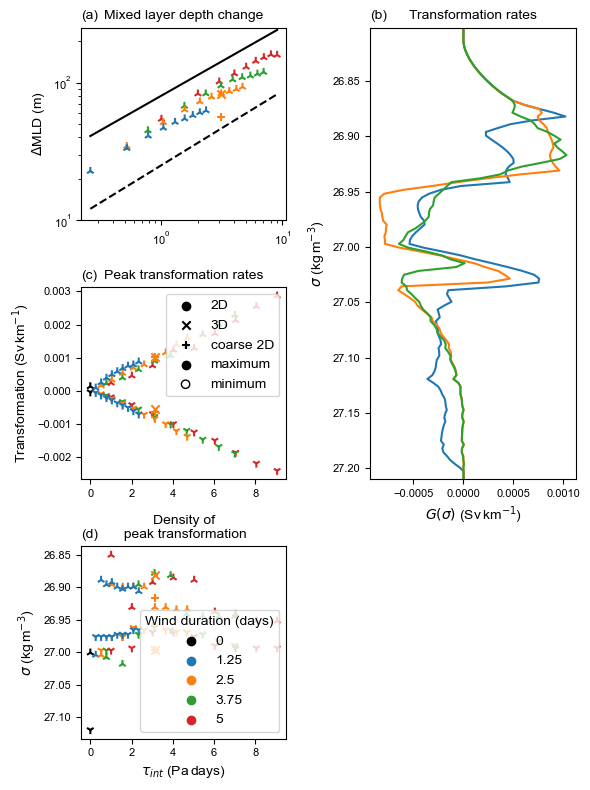

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(6, 8))

axs[0, 1].remove()
axs[1, 1].remove()
axs[2, 1].remove()
#axs[3, 1].remove()
#axs[3, 0].remove()
axbig = fig.add_subplot(3, 2, (2, 4))

plot_mld(axs[0, 0])
plot_transformation_rates(axs[1, 0])
plot_transformation_density(axs[2, 0])
plot_transformation_in_density_space(axbig)


axs[0, 0].set_title("Mixed layer depth change")
axbig.set_title("Transformation rates")
axs[1, 0].set_title("Peak transformation rates")
axs[2, 0].set_title("Density of\n peak transformation")

axs[0, 0].set_title("(a)", loc="left")
axbig.set_title("(b)", loc="left")
axs[1, 0].set_title("(c)", loc="left")
axs[2, 0].set_title("(d)", loc="left")


axs[1, 0].scatter(-np.inf, np.inf, c="k", marker="o", label="2D")
axs[1, 0].scatter(-np.inf, np.inf, c="k", marker="x", label="3D")
axs[1, 0].scatter(-np.inf, np.inf, c="k", marker="+", label="coarse 2D")
axs[1, 0].scatter(-np.inf, np.inf, c="k", label="maximum")
axs[1, 0].scatter(-np.inf, np.inf, color="k", facecolor="none", label="minimum")
axs[1, 0].legend()

axs[2, 0].scatter(-np.inf, np.inf, c="k", label="0")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:blue", label="1.25")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:orange", label="2.5")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:green", label="3.75")
axs[2, 0].scatter(-np.inf, np.inf, c="tab:red", label="5")
axs[2, 0].legend(title="Wind duration (days)")

axs[0, 0].set_ylabel("$\\Delta$MLD (m)")
axs[1, 0].set_ylabel("Transformation (Sv$\,$km$^{-1}$)")
axs[2, 0].set_ylabel("$\\sigma$ (kg$\,$m$^{-3}$)")

axs[2, 0].set_xlabel("$\\tau_{int}$ (Pa$\,$days)")
axbig.set_xlabel("$G(\\sigma)$ (Sv$\,$km$^{-1}$)")
axbig.set_ylabel("$\\sigma$ (kg$\,$m$^{-3}$)")

fig.tight_layout()
fig.show()
fig.savefig(base_path / "figures/Mixing.pdf")

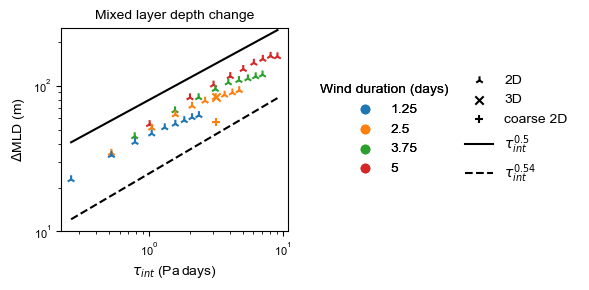

2023-08-08 14:59:57,950 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 2 memory: 75 MB fds: 26>>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/irminger-proj/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/irminger-proj/lib/python3.11/site-packages/distributed/system_monitor.py", line 160, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/irminger-proj/lib/python3.11/site-packages/psutil/__init__.py", line 2119, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2023-08-08 22:55:05,953 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(6, 9/3), width_ratios=[2.5, 3])
plot_mld(axs[0])
axs[0].set_title("Mixed layer depth change")
axs[0].set_ylabel("$\\Delta$MLD (m)")
axs[0].set_xlabel("$\\tau_{int}$ (Pa$\,$days)")


h0 = axs[1].scatter(-np.inf, np.inf, c="k", marker="2", label="2D")
hx = axs[1].scatter(-np.inf, np.inf, c="k", marker="x", label="3D")
hp = axs[1].scatter(-np.inf, np.inf, c="k", marker="+", label="coarse 2D")
l1 = axs[1].plot(-np.inf, np.inf, c="k", ls="--", label="$\\tau_{int}^{0.54}$")[0]
l2 = axs[1].plot(-np.inf, np.inf, c="k", ls="-", label="$\\tau_{int}^{0.5}$")[0]

marker_leg = plt.legend(handles=[h0, hx, hp, l2, l1], loc="center right", frameon=False, alignment="center")

hb = axs[1].scatter(-np.inf, np.inf, c="tab:blue", label="1.25")
ho = axs[1].scatter(-np.inf, np.inf, c="tab:orange", label="2.5")
hg = axs[1].scatter(-np.inf, np.inf, c="tab:green", label="3.75")
hr = axs[1].scatter(-np.inf, np.inf, c="tab:red", label="5")
colour_leg = plt.legend(
    handles=[hb, ho, hg, hr], loc="center left", frameon=False, title="Wind duration (days)",
    alignment="center",
)

axs[1].add_artist(marker_leg)
axs[1].add_artist(colour_leg)
axs[1].set_axis_off()



fig.tight_layout()
fig.savefig(base_path / "reports/Mixing.pdf", transparent=True)


In [37]:
transformation_ensemble.max(dim="run")
transformation_ensemble.min(dim="run")


<xarray.DataArray 'ensemble' (classs: 131)>
array([-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
       -0.0000000e+00,  1.3306720e-06,  8.8711467e-06,  2.1041253e-05,
        3.7799404e-05,  5.7399091e-05,  8.1198712e-05,  1.0711909e-04,
        1.3719783e-04,  1.7033987e-04,  2.0521459e-04,  2.4455256e-04,
        2.8584499e-04,  3.3233536e-04,  3.8157019e-04,  4.3830398e-04,
        5.0471281e-04,  6.1267748e-04,  7.5666723e-04,  9.0480153e-04,
        1.0646485e-03,  1.2291528e-03,  1.2907241e-03,  1.3176149e-03,
        1.4216708e-03,  1.5437460e-03,  1.6327486e-03,  1.7300122e-03,
        1.8308247e-03,  1.9392327e-03,  2.0390055e-03,  2.1484669e-03,
        2.2574298e-03,  2.3491075e-03,  2.4400505e-03,  2.5341124e-03,
        2.6107510e-03,  2.6732511e-03,  2.7557942e-03,  2.8231598e-03,
        2.8699273e-03,  2.5754746e-03,  2.2825189e-03,  2.0311465e-03,
        1.5389365e-03,  1.1218400e-03,  3.0911810e-04, -3.1742071e-05,
        8.0394983e-07,  1.8851209e-06,  2.2455113e-06,  2.8138190e-06,
        2.8276802e-06,  6.3345551e-06,  1.3466124e-04,  1.6284095e-04,
        2.4695057e-04,  3.0507043e-04,  3.9513846e-04,  4.5626817e-04,
        5.1035883e-04,  5.6324870e-04,  6.0347380e-04,  5.6208391e-04,
        4.7918042e-04,  4.8760796e-04,  4.3640513e-04,  3.6288550e-04,
        8.7740327e-06, -9.1476289e-07, -8.4543484e-07,  9.6749873e-06,
        1.0409607e-05, -1.1504249e-06, -1.1504249e-06,  3.9502138e-06,
       -2.5643083e-06, -1.9683002e-06,  3.4253824e-06,  9.6886915e-06,
       -1.5663487e-06, -1.5247430e-06,  3.1047355e-06, -1.7187994e-06,
       -1.8020107e-06, -6.2582137e-07,  2.9064363e-06,  5.9393926e-07,
       -3.5900463e-05, -1.5663267e-06,  5.1837419e-06, -1.1644192e-06,
       -1.4416426e-06, -1.3446366e-06, -1.4278037e-06, -1.4694093e-06,
        3.5463256e-06, -1.3862866e-06, -1.3447253e-06,  4.4670915e-06,
       -1.4417312e-06, -1.5526207e-06, -1.5803430e-06, -1.5941819e-06,
       -1.4832926e-06,  8.4956855e-06, -1.6496266e-06, -1.7189103e-06,
        1.3977301e-06,  2.9258786e-06,  3.9371448e-06,  1.7439406e-06,
        1.9898509e-06,  1.9898509e-06,  1.9898509e-06,  1.9898509e-06,
        1.9898509e-06,  1.9898509e-06,  1.9898509e-06,  1.9898509e-06,
        1.9898509e-06,  1.9898509e-06,  1.9898509e-06,  1.9898509e-06,
        1.9898509e-06,  1.9898509e-06,  1.9898509e-06], dtype=float32)
Coordinates:
    XC       float32 ...
  * classs   (classs) int64 0 1 2 3 4 5 6 7 ... 123 124 125 126 127 128 129 130
    iter     int64 ...
    time     timedelta64[ns] ...

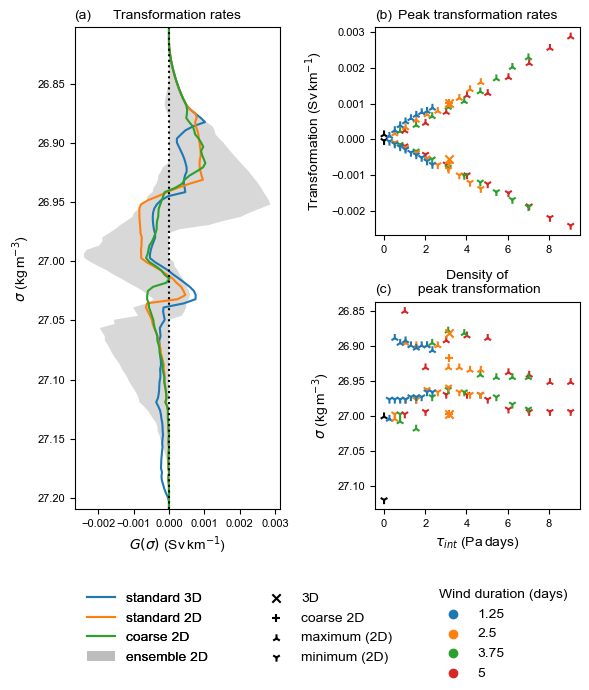

In [54]:
fig, axs = plt.subplots(3, 2, figsize=(6, 7), height_ratios=(1, 1, .5))

axs[0, 0].remove()
axs[1, 0].remove()
axs[2, 0].remove()
axs[2, 1].remove()
axbig = fig.add_subplot(3, 2, (1, 3))
axleg = fig.add_subplot(3, 2, (5, 6))
axleg.set_axis_off()

plot_transformation_rates(axs[0, 1])
plot_transformation_density(axs[1, 1])

ens_fill = axbig.fill_betweenx(
    ensemble_class["rho_intermediate"] - 1000,
    transformation_ensemble.quantile(0.0, dim="run"),
    transformation_ensemble.quantile(1.0, dim="run"),
    color="grey",
    alpha=0.3,
    edgecolor=None,
    label="ensemble 2D"
)
plot_transformation_in_density_space(axbig)
axbig.axvline(0, c="k", ls=":")


axbig.set_title("Transformation rates")
axs[0, 1].set_title("Peak transformation rates")
axs[1, 1].set_title("Density of\n peak transformation")

axs[0, 1].set_title("(b)", loc="left")
axbig.set_title("(a)", loc="left")
axs[1, 1].set_title("(c)", loc="left")

mx = axs[1, 1].scatter(-np.inf, np.inf, c="k", marker="x", label="3D")
mp = axs[1, 1].scatter(-np.inf, np.inf, c="k", marker="+", label="coarse 2D")
m2 = axs[1, 1].scatter(-np.inf, np.inf, c="k", marker="2", label="maximum (2D)")
m1 = axs[1, 1].scatter(-np.inf, np.inf, c="k", marker="1", label="minimum (2D)")

marker_leg = plt.legend(handles=[mx, mp, m2, m1], frameon=False, loc="center")
axleg.add_artist(marker_leg)



hb = axs[1, 1].scatter(-np.inf, np.inf, c="tab:blue", label="1.25")
ho = axs[1, 1].scatter(-np.inf, np.inf, c="tab:orange", label="2.5")
hg = axs[1, 1].scatter(-np.inf, np.inf, c="tab:green", label="3.75")
hr = axs[1, 1].scatter(-np.inf, np.inf, c="tab:red", label="5")
colour_leg = plt.legend(
    handles=[hb, ho, hg, hr], loc="upper right", frameon=False, title="Wind duration (days)",
    alignment="left",
)
axleg.add_artist(colour_leg)


s3d = axs[1, 0].plot(-np.inf, np.inf, label="standard 3D")[0]
s2d = axs[1, 0].plot(-np.inf, np.inf, label="standard 2D")[0]
c2d = axs[1, 0].plot(-np.inf, np.inf, label="coarse 2D")[0]


ds_leg = plt.legend(
    handles=[s3d, s2d, c2d, ens_fill],
    frameon=False,
    loc="center left"
)
axleg.add_artist(ds_leg)


axs[0, 1].set_ylabel("Transformation (Sv$\,$km$^{-1}$)")
axs[1, 1].set_ylabel("$\\sigma$ (kg$\,$m$^{-3}$)")

axs[1, 1].set_xlabel("$\\tau_{int}$ (Pa$\,$days)")
axbig.set_xlabel("$G(\\sigma)$ (Sv$\,$km$^{-1}$)")
axbig.set_ylabel("$\\sigma$ (kg$\,$m$^{-3}$)")

fig.tight_layout()
fig.savefig(base_path / "reports/Transformation.pdf", transparent=True)